# Classification sample on Rotten Tomatoes movie reviews

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# this allows plots to appear directly in the notebook
%matplotlib inline

# prettify charts
plt.style.use('ggplot')

## Import & inspect data
Data set taken from [Kaggle: Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews).

Some examples:

  * 4 (positive): "They works spectacularly well... A shiver-inducing, nerve-rattling ride."
  * 3 (somewhat positive): "rooted in a sincere performance by the title character undergoing midlife crisis"
  * 2 (neutral): "Its everything you would expect -- but nothing more."
  * 1 (somewhat negative): "But it does not leave you with much."
  * 0 (negative): "The movies progression into rambling incoherence gives new meaning to the phrase fatal script error."

In [2]:
phrases = pd.read_csv('d:/docs/ml/datas/movies/train.tsv', sep = '\t', index_col = 0)

In [77]:
phrases.head()

,SentenceId,Phrase,Sentiment,WordsCount,PositivesCount,NegativesCount
PhraseId,,,,,,
64,2,"This quiet , introspective and entertaining in...",4,9,2,0
67,2,"quiet , introspective and entertaining indepen...",4,5,1,0
75,2,entertaining,4,1,1,0
78,2,is worth seeking,4,3,1,0
102,3,would have a hard time sitting through this one,0,9,0,0


In [7]:
phrases.shape

(156060, 3)

In [12]:
phrases = phrases[(phrases.Sentiment == 0) | (phrases.Sentiment == 4)]
phrases.shape

(16278, 3)

In [20]:
phrases.head()

,SentenceId,Phrase,Sentiment,WordsCount
PhraseId,,,,
64,2,"This quiet , introspective and entertaining in...",4,9
67,2,"quiet , introspective and entertaining indepen...",4,5
75,2,entertaining,4,1
78,2,is worth seeking,4,3
102,3,would have a hard time sitting through this one,0,9


### What do the sentences look like?

In [14]:
# print the first sentence
phrases.iloc[0]['Phrase']

'This quiet , introspective and entertaining independent is worth seeking .'

In [16]:
phrases.loc[lambda row: row.SentenceId == 3].iloc[0]['Phrase']
#df.loc[lambda row: row.SentenceId == 2]

'would have a hard time sitting through this one'

## Okay, let's go

### Count words

In [18]:
import re
re.findall('\w+', " a,   bee and don't see.")

['a', 'bee', 'and', 'don', 't', 'see']

In [19]:
phrases['WordsCount'] = phrases.apply(lambda row: len(re.findall('\w+', row['Phrase'])), axis = 1)
# small['WordsCount'] = small.apply(lambda row: len(row['Phrase'].split()), axis = 1)

### Build collections of positive & negative words, respectively

In [61]:
positives = phrases[(phrases['WordsCount'] <= 4) & (phrases['Sentiment'] == 4)]
# positives.drop_duplicates(subset = 'Phrase')
positives.head()
positives.shape

(2790, 6)

In [62]:
negatives = phrases[(phrases['WordsCount'] <= 4) & (phrases['Sentiment'] == 0)]
# negatives.drop_duplicates(subset = 'Phrase')
# negatives.head()
negatives.shape
# negatives

(1696, 6)

### For each phrase, count the positives and the negatives within...

That's gonna take a while... :-<

In [63]:
posphrases = positives['Phrase'].values

In [64]:
negphrases = negatives['Phrase'].values

In [65]:
def count_occurences(phrase, sublist):
    counter = 0
    for sub in sublist:
        counter += phrase.count(sub)
    return counter

In [66]:
count_occurences("thrilling and high hilarity", posphrases)

2

In [67]:
phrases['PositivesCount'] = phrases.apply(
    lambda row: count_occurences(row['Phrase'], posphrases), axis = 1)

phrases['NegativesCount'] = phrases.apply(
    lambda row: count_occurences(row['Phrase'], negphrases), axis = 1)

In [78]:
phrases.head()

,SentenceId,Phrase,Sentiment,WordsCount,PositivesCount,NegativesCount
PhraseId,,,,,,
64,2,"This quiet , introspective and entertaining in...",4,9,2,0
67,2,"quiet , introspective and entertaining indepen...",4,5,1,0
75,2,entertaining,4,1,1,0
78,2,is worth seeking,4,3,1,0
102,3,would have a hard time sitting through this one,0,9,0,0


In [81]:
# remove phrases with 0 negatives and 0 positives
phrases = phrases[phrases.PositivesCount + phrases.NegativesCount > 0]
phrases.shape

(12221, 6)

### Now let's draw something...

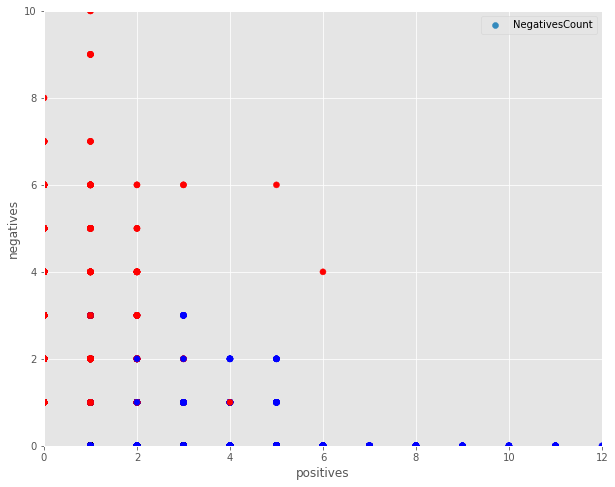

In [82]:
# setup figure
plt.figure(figsize=(10, 8))

# scatter plot of positive phrases (x) and negative phrases (y)
ax1=plt.subplot(111)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax1.scatter(phrases.PositivesCount, phrases.NegativesCount, c = (phrases.Sentiment == 4), cmap = cm_bright)
ax1.set_xlim((phrases.PositivesCount.min(), phrases.PositivesCount.max()))
ax1.set_ylim((phrases.NegativesCount.min(), phrases.NegativesCount.max()))
ax1.set_xlabel('positives')
ax1.set_ylabel('negatives')
ax1.legend(loc = 'upper right')

In [83]:
from sklearn.linear_model import LinearRegression

# get feature/predictor matrix as numpy array
X = phrases[['PositivesCount', 'NegativesCount']].values

# encode class labels
classes, y = np.unique(phrases.Sentiment.values, return_inverse = True)
newy = []
for v in y:
    if v == 0:
        newy.append(-1)
    else:
        newy.append(1)
y = newy
# map {0, 4} to {-1, 1}

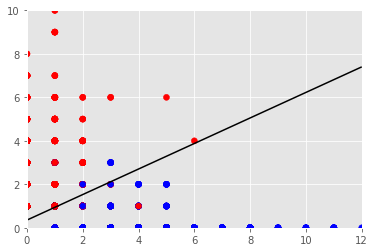

In [84]:
# fit OLS regression 
est = LinearRegression(fit_intercept=True, normalize=True)
est.fit(X, y)

# plot data and decision surface
ax = plt.gca()
ax.scatter(phrases.PositivesCount, phrases.NegativesCount, c = (phrases.Sentiment == 4), cmap = cm_bright)
try:
    plot_surface(est, X[:, 0], X[:, 1], ax=ax)
except NameError:
    print('Please run cells in Appendix first')

## Confusion matrix and misclassification rate

In [85]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# the larger operator will return a boolean array which we will cast as integers for fancy indexing
y_pred = (2 * (est.predict(X) > 0.0)) - 1

In [86]:
def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data = cm, columns = [-1, 1], index = [-1, 1])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm

confusion_matrix(y, y_pred)

error rate: 0.06


Predicted label,-1,1
True label,,
-1,4269,557
1,166,7229


### Appendix:

In [33]:
# utility function to plot the decision surface
def plot_surface(est, x_1, x_2, ax=None, threshold=0.0, contourf=False):
    """Plots the decision surface of ``est`` on features ``x1`` and ``x2``. """
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]  # convert 2d grid into seq of points
    if hasattr(est, 'predict_proba'):  # check if ``est`` supports probabilities
        # take probability of positive class
        pred = est.predict_proba(X_pred)[:, 1]
    else:
        pred = est.predict(X_pred)
    Z = pred.reshape((100, 100))  # reshape seq to grid
    if ax is None:
        ax = plt.gca()
    # plot line via contour plot

    if contourf:
        ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1.0, 10), cmap=plt.cm.RdBu, alpha=0.6)
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

def plot_datasets(est=None):
    """Plotsthe decision surface of ``est`` on each of the three datasets. """
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    for (name, ds), ax in zip(datasets.iteritems(), axes):
        X_train = ds['X_train']
        y_train = ds['y_train']
        X_test = ds['X_test']
        y_test = ds['y_test']

        # plot test lighter than training
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
        # plot limits
        ax.set_xlim(X_train[:, 0].min(), X_train[:, 0].max())
        ax.set_ylim(X_train[:, 1].min(), X_train[:, 1].max())
        # no ticks
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_0$')
        ax.set_title(name)
        if est is not None:
            est.fit(X_train, y_train)
            plot_surface(est, X_train[:, 0], X_train[:, 1], ax=ax, threshold=0.5, contourf=True)
            err = (y_test != est.predict(X_test)).mean()
            ax.text(0.88, 0.02, '%.2f' % err, transform=ax.transAxes)

    fig.subplots_adjust(left=.02, right=.98)